__Regression of Air France Revenue:__

In [353]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# Hierarchical CLustering of OECD Composite Indicator
# Import normalize
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import pdb
mpl.rcParams['figure.figsize'] = 20, 5
mpl.rcParams['lines.linewidth'] = 2

In [354]:
mpl.rcParams['figure.figsize'] = 20, 5
mpl.rcParams['lines.linewidth'] = 2
df = pd.read_excel('fpregress.xlsx', parse_dates=['Dates'], index_col='Dates')
data = df.fillna(method='ffill').fillna(method='bfill').dropna(axis=1).pct_change().fillna(0)
data.head(40).iloc[[0,2,-2,-1],:]

,SALES_REV_TURN,EBITDA,OPER_MARGIN,LOAD_FACTOR,BS_INVENTORIES,BS_ACCT_NOTE_RCV,BS_ACCT_PAYABLE,TOTAL_EQUITY,BS_TOT_ASSET,SHORT_AND_LONG_TERM_DEBT,REV_PASS_CARRIED,YIELD_PER_PASS_MILES_KM,CURRENT_FUEL_HEDGE_PERC,FUEL_EXPENSES,AVERAGE_PASSENGER_FARE,CF_FREE_CASH_FLOW,PE_RATIO,CO1 Comdty,VGK US Equity,OEOEKLAR Index
Dates,,,,,,,,,,,,,,,,,,,,
2001-06-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2001-12-28,-0.093545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.055926,0.000000,0.004450
2011-09-30,0.088608,1.738095,-3.530965,0.067224,0.003373,-0.014733,-0.008061,-0.055657,-0.034258,0.007088,0.066315,-0.050811,0.0,0.026300,0.100177,-0.003521,0.0,-0.043682,0.181275,0.019261
2011-12-30,-0.110980,-0.722981,-1.642364,-0.053885,-0.016807,-0.150467,0.111634,-0.021359,-0.015213,-0.009196,-0.109215,0.033045,0.0,-0.055329,0.000000,-0.731449,0.0,0.152839,-0.001100,0.013175


                labels
countries             
SALES_REV_TURN       3
EBITDA               1
OPER_MARGIN          1
LOAD_FACTOR          3
BS_INVENTORIES       3


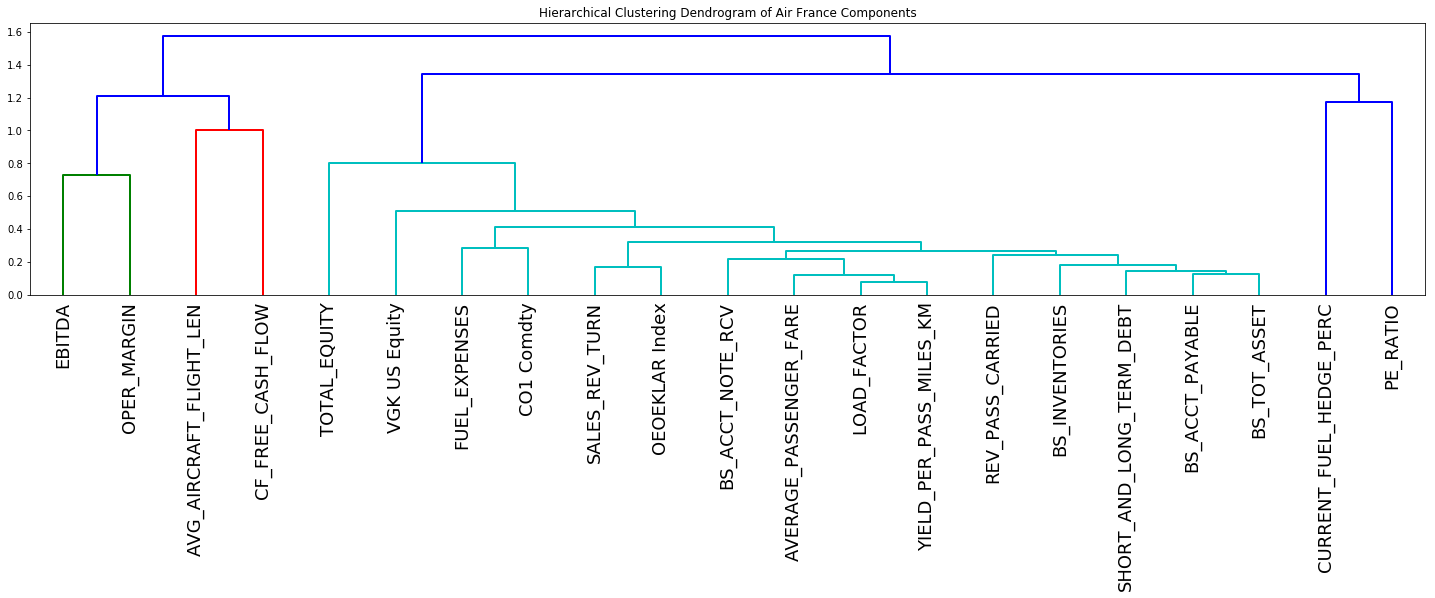

In [355]:
df_quadratic = df.resample('D').interpolate(method='quadratic')
x = df_quadratic.fillna(0).T

# Normalize the movements: normalized_movements
normalized_movements = normalize(x)

# Calculate the linkage: mergings
mergings = linkage(normalized_movements, method='complete')

labels = fcluster(mergings, 1.2, criterion='distance')
labels = pd.DataFrame({'labels':labels, 'countries':x.index}).set_index('countries')
print(labels.head())

# Plot the dendrogram
labelList = [i for i in x.index]

plt.figure(figsize=(25, 5))
plt.title('Hierarchical Clustering Dendrogram of Air France Components')
dendrogram(mergings,
           truncate_mode='level',
           leaf_rotation=90.,
           leaf_font_size=18.,
           labels=labelList,
           show_contracted=True)
plt.show();

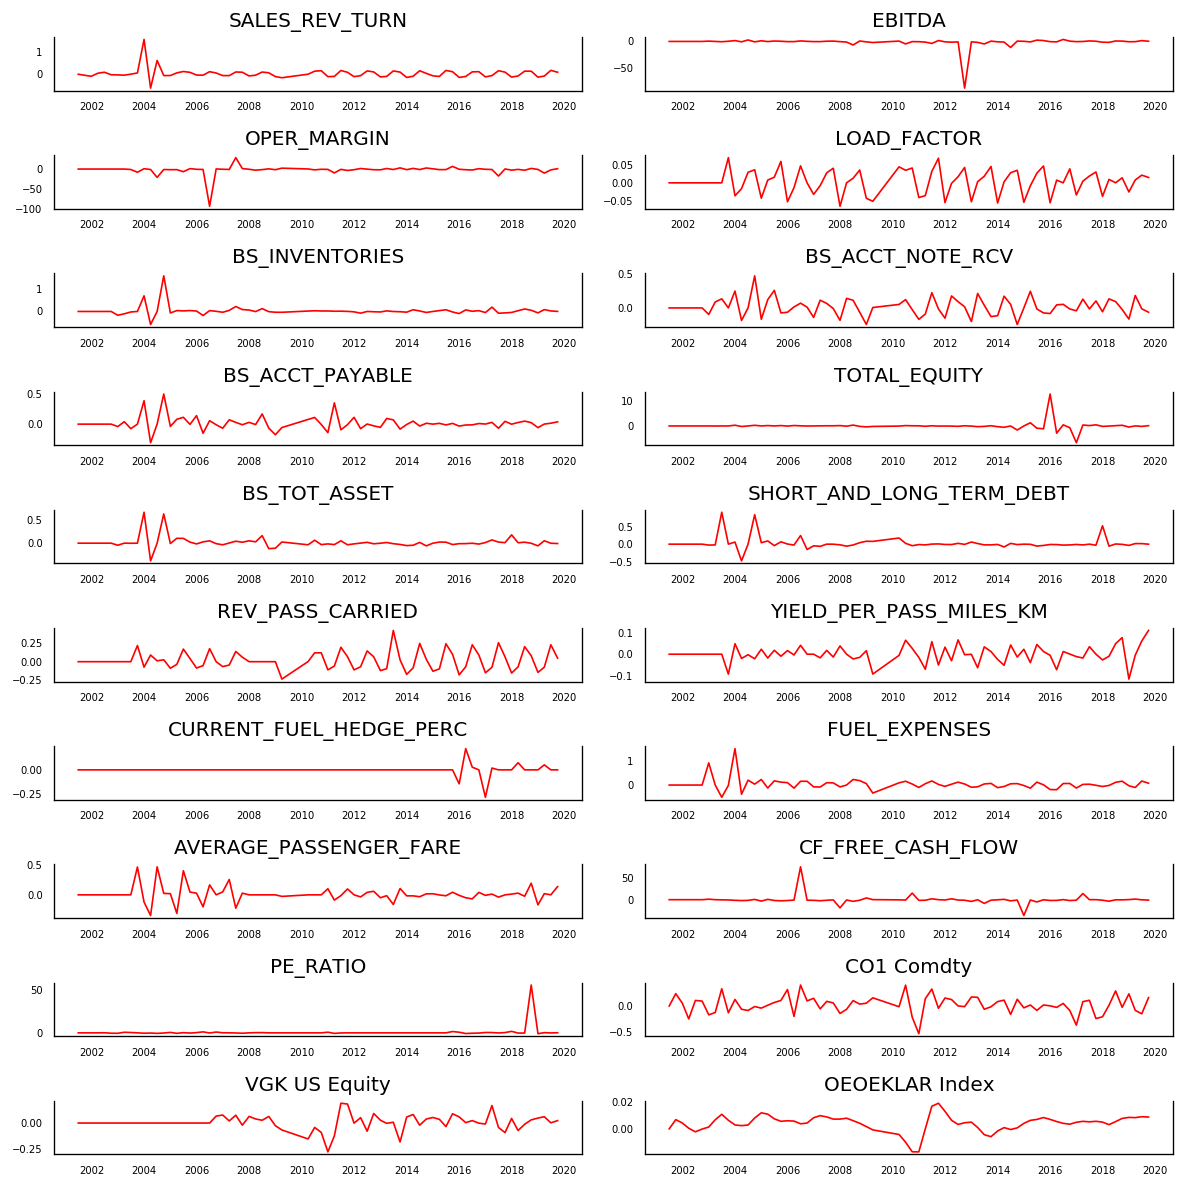

In [356]:
df = data
# Plot
fig, axes = plt.subplots(nrows=10, ncols=2, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [357]:
# df_model = df_model.drop(columns='Adj Close')
features_names = ((df_model.columns).tolist())[1:]

In [537]:
features_names_model = features_names
features = (df_model[features_names_model]).dropna()

y_names = ['SALES_REV_TURN']
y = df_model[y_names].dropna()
x = features

targets = df_model[y_names]
feature_target_df = df_model[y_names + features_names_model].dropna()

In [538]:
linear_features = features[:]
targets_df = targets[:]

quarter = []
trendline = []
Q1 = []
Q2 = []
Q3 = []
Q4 = []

for i in linear_features.reset_index()['Dates']:
    quarter.append(i.quarter)
    
for i in range(len(quarter)): trendline.append(i)
for i in quarter: Q1.append(1) if i == 1 else Q1.append(0)
for i in quarter: Q2.append(1) if i == 2 else Q2.append(0)
for i in quarter: Q3.append(1) if i == 3 else Q3.append(0)
for i in quarter: Q4.append(1) if i == 4 else Q4.append(0)

linear_features['trendline'] = trendline
linear_features['Q1'] = Q1
linear_features['Q2'] = Q2
linear_features['Q3'] = Q3
linear_features['Q4'] = Q4

__Test-Train split__

In [539]:

# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
# linear_features = sm.add_constant(features)
model_features = linear_features[12:]
targets = targets[12:]
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.70 * model_features.shape[0])
train_features = X = model_features[:train_size]
train_targets  = Y = targets[:train_size]
test_features  = x = model_features[train_size:]
test_targets   = y = targets[train_size:]

print(linear_features.shape, train_features.shape, test_features.shape)

(71, 24) (41, 24) (18, 24)


In [540]:
# Create the linear model and complete the least squares fit > 'trendline', 'Q1', 'Q2', 'Q3', 'Q4'
name = ['AVERAGE_PASSENGER_FARE', 'BS_ACCT_PAYABLE', 'trendline', 'Q1', 'Q2', 'Q3', 'Q4']

if len(name) == 0:
    name = X.columns.tolist()
    model = sm.OLS(Y, X[name])
else:
    model = sm.OLS(Y, X[name])

results = model.fit()  # fit the model
print(results.summary(), results.pvalues.sort_values(ascending=True))
# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0


# Make predictions from our model for train and test sets
train_predictions = Yhat = results.predict(X[name])
test_predictions = yhat = results.predict(x[name])

                            OLS Regression Results                            
Dep. Variable:         SALES_REV_TURN   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     21.51
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           2.93e-10
Time:                        23:14:30   Log-Likelihood:                -293.01
No. Observations:                  41   AIC:                             600.0
Df Residuals:                      34   BIC:                             612.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
AVERAGE_PASSENGER_FARE     4

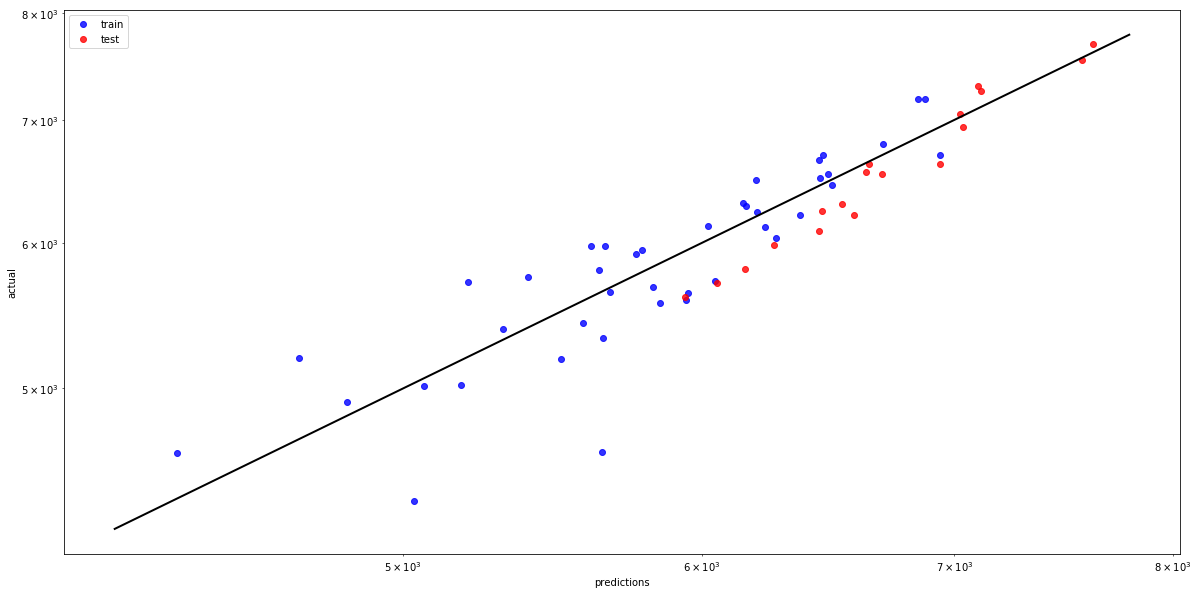

In [541]:
# Scatter the predictions vs the targets with 80% transparency
plt.figure(figsize=(20,10))
plt.scatter(Yhat, Y, alpha=0.8, color='b', label='train')
plt.scatter(yhat, y, alpha=0.8, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), color='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

R² in sample:  0.792
R² Out-of-sample:  0.849


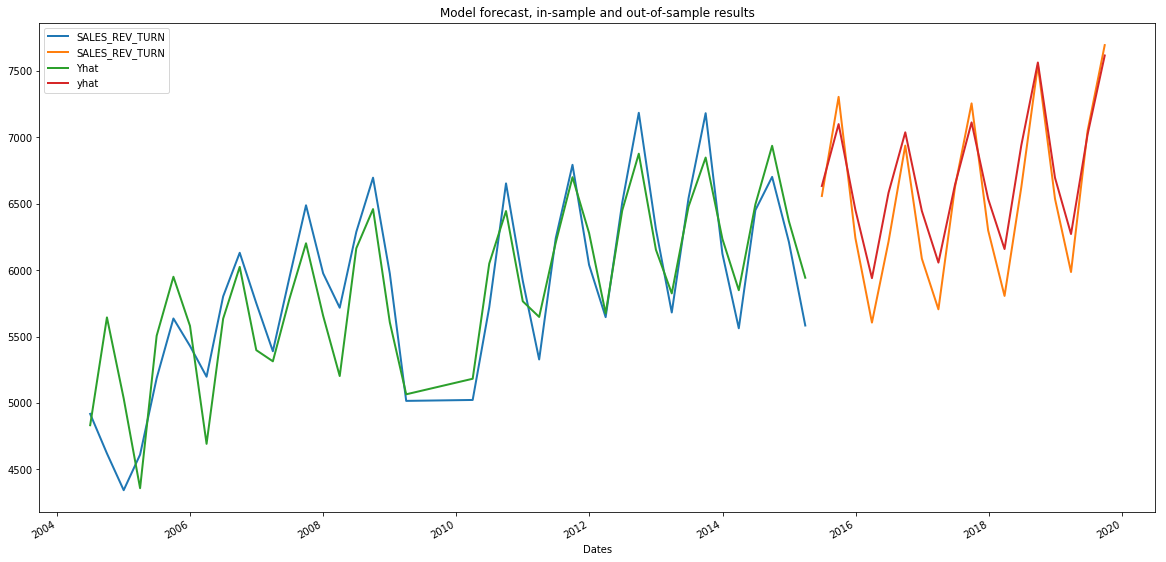

In [542]:

def plot_test_train_results(Y, y, Yhat, yhat):
    ax = Y.plot(figsize=(20,10))
    y.plot(ax=ax)
    Yhat.plot(ax=ax, label='Yhat', legend='Yhat')
    yhat.plot(ax=ax, label='yhat', legend='yhat')
    plt.title('Model forecast, in-sample and out-of-sample results')
    print("R² in sample: ", r2_score(Y, Yhat).round(3))
    print("R² Out-of-sample: ", r2_score(y, yhat).round(3))
    
plot_test_train_results(Y, y, Yhat, yhat)

__Regression using Random Forest Regressor__

In [543]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9686412741423513
0.2365683528453032


In [562]:
def plot_test_train_results(model, Y, y):
    Y_hat = pd.DataFrame(cross_val_predict(model, X, Y.values.ravel(), cv=5))
    y_hat = pd.DataFrame(cross_val_predict(model, x, y.values.ravel(), cv=5))
    Y_and_y = (Y.values.tolist()).append(y.values.tolist())
#     Yhat_and_yhat = (Yhat.values.tolist()).append(yhat.values.tolist())
    
    Yhat = Y.join(Y_hat.set_index(Y.index))
    Yhat.columns = [y_names[0], 'Forecast in-sample']
    yhat = y.join(y_hat.set_index(y.index))
    yhat.columns = [y_names[0], 'Forecast out-of-sample']
        
    ax = Yhat.plot()
    yhat.plot(ax=ax)
    labels = [y_names, 'Forecast -In-sample', y_names, 'Forecast -Out-of-sample', 'predictions using Random Forest model']
    plt.title('Model forecast, in-sample and out-of-sample results', fontsize=20)
    #Print results & comments    
    print()
    print('Mean Y: ', np.mean(Y).round(3))
    print('Mean predictions: ', np.mean(Yhat).round(3))
    print()
    print('Score of model in sample:', model.score(X, Y).round(3))
    print('Score of model out-of-sample:',model.score(x, y).round(3))
    print()
    print("R² in sample: ", r2_score(Y, Y_hat).round(3))
    print("R² Out-of-sample: ", r2_score(y, y_hat).round(3))

def map_importance(model):   
    # Plot the graph
    # Exrtract features importance with built-in function of random forest regressor
    features_importances = rfr.feature_importances_

    # Sort the index that will be our reference for the positino of each index regarding there importances
    sorted_index = np.argsort(features_importances)[::-1]

    # Create the corresponding labels to importances position
    features_count = range(len(sorted_index))
    labels = np.array(linear_features.columns.to_list())[sorted_index]
    mpl.rcParams['figure.figsize'] = 20 , 5
    plt.bar(features_count, features_importances[sorted_index], tick_label=labels)
    plt.xticks(rotation=90)
    plt.show()

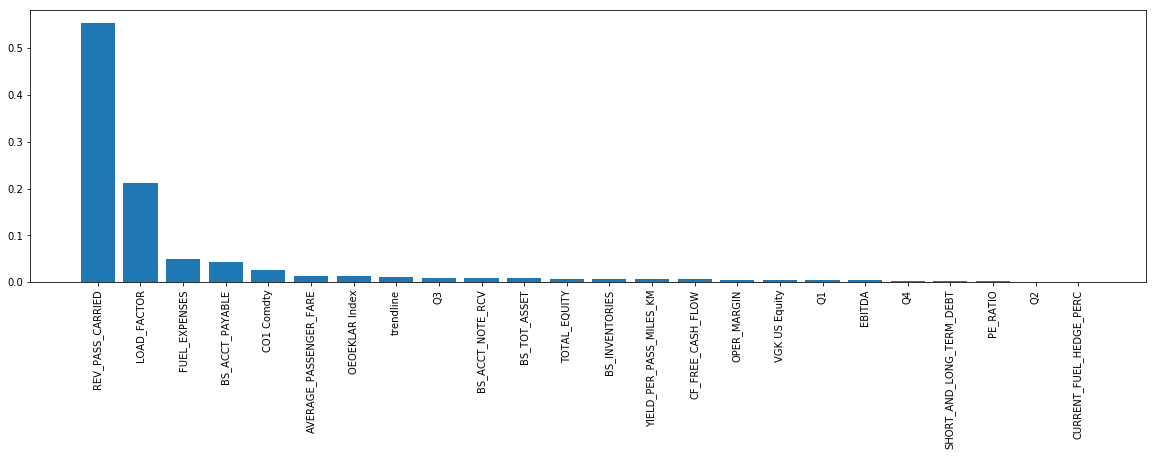


Mean Y:  SALES_REV_TURN    5866.39
dtype: float64
Mean predictions:  SALES_REV_TURN        5866.390
Forecast in-sample    6036.542
dtype: float64

Score of model in sample: 0.969
Score of model out-of-sample: 0.237

R² in sample:  0.402
R² Out-of-sample:  0.849


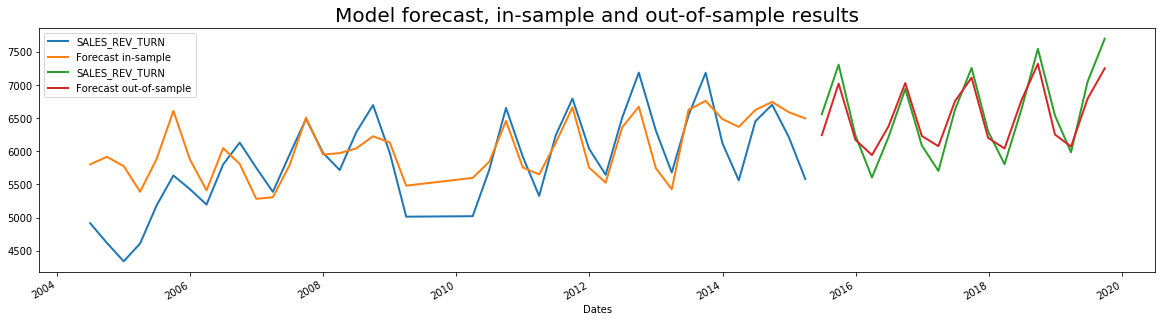

In [563]:
map_importance(rfr)
plot_test_train_results(rfr, Y, y)

__Gradient Boosting Regressors__

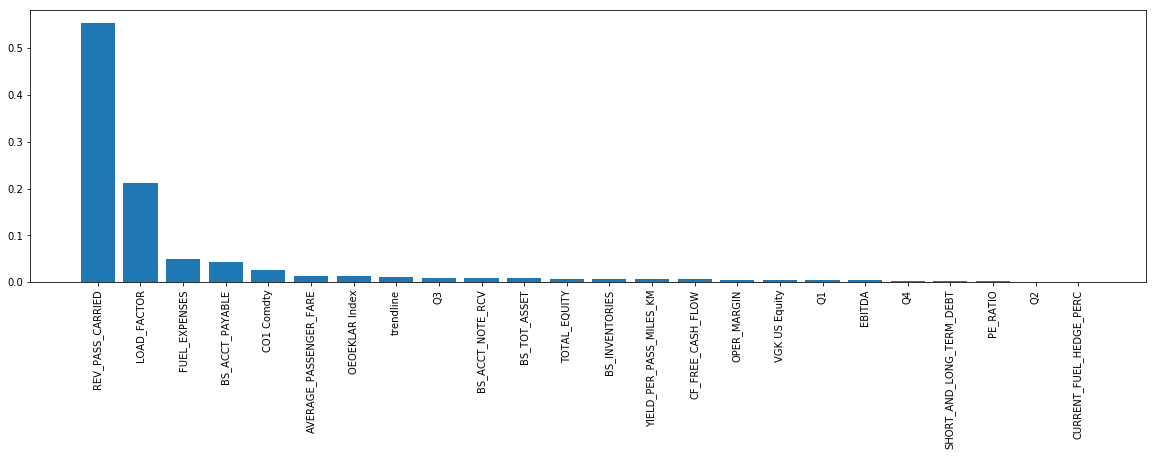


Mean Y:  SALES_REV_TURN    5866.39
dtype: float64
Mean predictions:  SALES_REV_TURN        5866.390
Forecast in-sample    6028.719
dtype: float64

Score of model in sample: 1.0
Score of model out-of-sample: 0.468

R² in sample:  0.505
R² Out-of-sample:  0.827


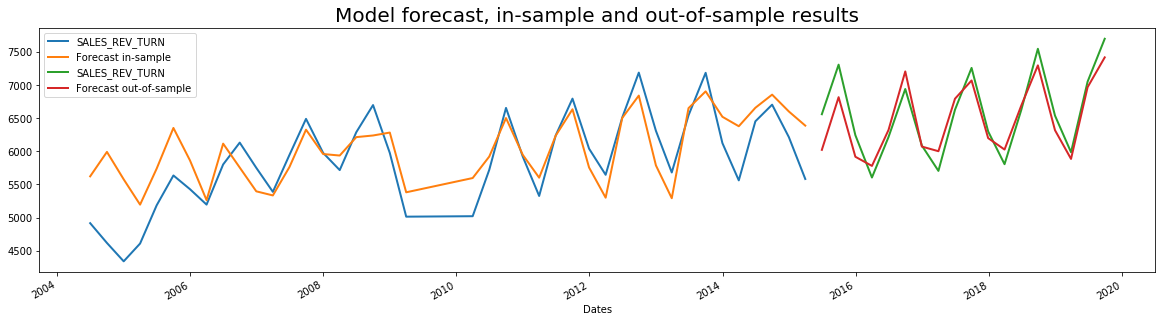

In [564]:
from sklearn.ensemble import GradientBoostingRegressor

gsc = GridSearchCV(
   estimator=GradientBoostingRegressor(),
   param_grid={
       'max_depth': range(2,5),
       'n_estimators': (50, 70, 150, 200, 400),
       'learning_rate': (0.05, 0.03, 0.02, 0.01),
#        'subsample': (0.3, 0.5,0.6, 0.7),
       'min_samples_split': (2, 4),
       'random_state': (42, 60, 80)},#,#
#        'loss': ('ls', 'huber', 'quantile', 'lad')},
   cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_

gbr = GradientBoostingRegressor(max_depth        = best_params["max_depth"],
                               n_estimators      = best_params["n_estimators"],
                               learning_rate     = best_params["learning_rate"],
#                                subsample         = best_params["subsample"],
                               min_samples_split = best_params["min_samples_split"],
#                                random_state      = best_params["random_state"],
#                                loss              = best_params["loss"],
                               verbose=False)

scores = cross_val_score(gbr, x, y.values.ravel(), cv=5, scoring='neg_mean_absolute_error')

# Perform K-Fold CV
gbr.fit(X,Y)
map_importance(gbr)
plot_test_train_results(gbr, Y, y)

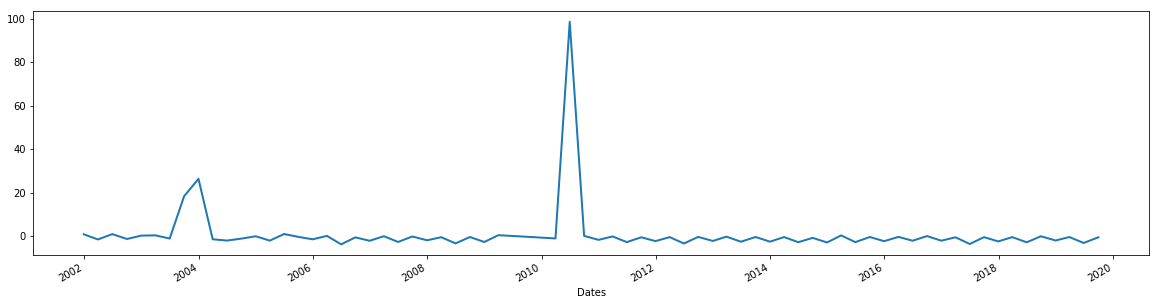

In [404]:
ax = (df['SALES_REV_TURN'].pct_change()).plot()

In [346]:
data_diff = data.dropna().diff(1).dropna()
data_diff.iloc[[0,2,-2,0],:]

,SALES_REV_TURN
Dates,
2001-09-28,-167.0
2002-03-28,133.0
2019-06-28,1064.0
2001-09-28,-167.0


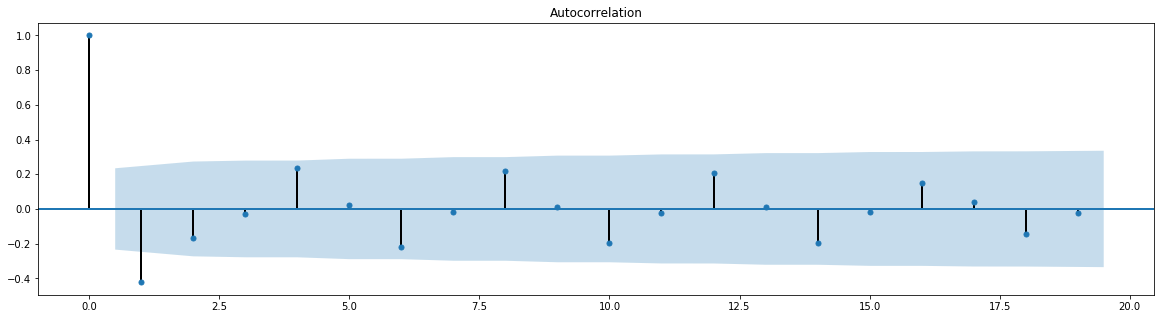

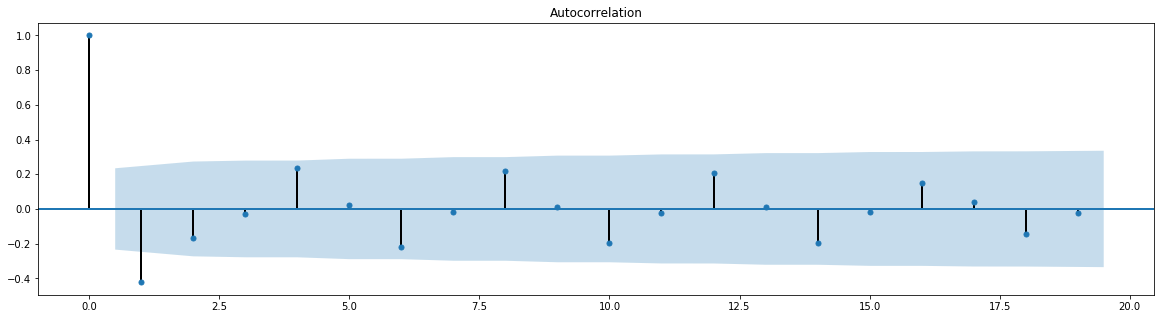

In [347]:
plot_acf(data_diff['SALES_REV_TURN'])